In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from svetlanna.phase_retrieval_problem import phase_retrieval
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna import LinearOpticalSetup

In [30]:
# optical setup sizem mm
lx = 8
ly = 8

# number of nodes
Nx = 3500
Ny = 3500
# wavelength
lam = 660 * 1e-6

# focal distance of the lens
focal = 100
# radius of the lens
r = 10
# distance between the screen od the lens
distance = focal

# waist radius of the gaussian beam, mm
w0 = 3

x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = np.meshgrid(x, y)


dx = lx / Nx
dy = ly / Ny

params = SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)


We solve the problem of direct propagation of a Gaussian beam through the 4f-system:

In [31]:
field_before_lens = Wavefront.gaussian_beam(simulation_parameters=params, distance=distance, waist_radius=w0)

intensity_source = field_before_lens.intensity.detach().numpy()

lens = elements.ThinLens(simulation_parameters=params, focal_length=focal, radius=r)

field_after_lens = lens.forward(input_field=field_before_lens)

free_space2 = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal) * 2, method='fresnel')
field_before_lens2 = free_space2.forward(input_field=field_after_lens)

lens2 = elements.ThinLens(simulation_parameters=params, focal_length=focal, radius=r)
field_after_lens2 = lens2.forward(input_field=field_before_lens2)

free_space3 = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal), method='fresnel')
output_field = free_space3.forward(input_field=field_after_lens2)

intensity_target = torch.pow(torch.abs(output_field), 2).detach().numpy()

optical_setup = LinearOpticalSetup([free_space2, lens2, free_space3])

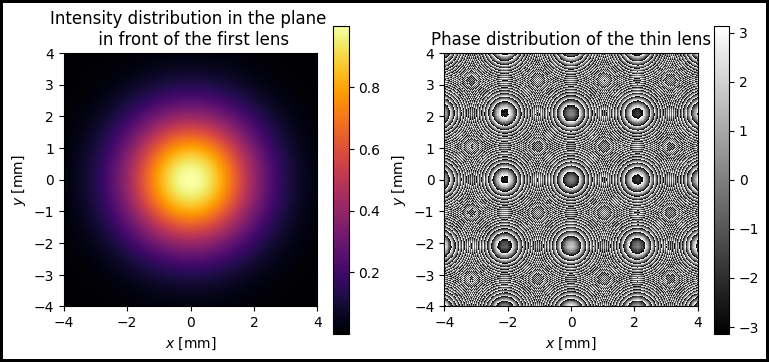

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(xv, yv, intensity_source, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title('Intensity distribution in the plane \n in front of the first lens')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im1 = ax[1].pcolormesh(xv, yv, torch.real((torch.log(lens.get_transmission_function())/1j)).detach().numpy(), cmap='gray')
ax[1].set_aspect('equal')
ax[1].set_title('Phase distribution of the thin lens')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

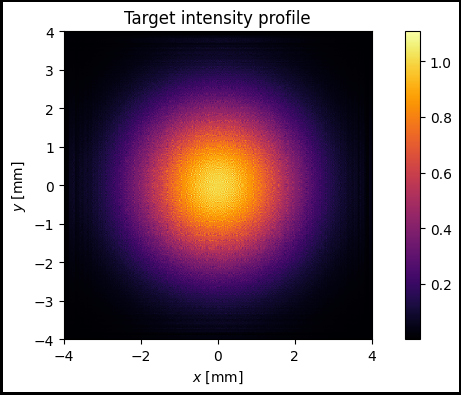

In [33]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Target intensity profile')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

Let's try to put SLM instead of the first lens and choose such a mask for it, which, when passing through the system, will generate an intensity profile higher than the first one:

In [34]:
result_hio = phase_retrieval.retrieve_phase(
    source_intensity=torch.tensor(intensity_source),
    optical_setup=optical_setup,
    target_intensity=torch.tensor(intensity_target),
    method='HIO',
    initial_phase=torch.tensor(xv**2)
)

phase_distribution_hio = result_hio.solution
niter_hio = result_hio.number_of_iterations
error_mass_hio = result_hio.cost_func_evolution


step = 2 * torch.pi / 256
mask = phase_distribution_hio // step

In [35]:
n_hio = np.arange(1, niter_hio+1)

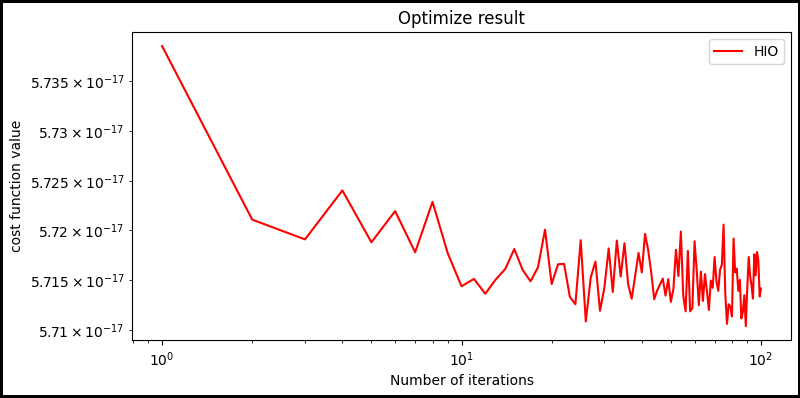

In [36]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)

ax.set_title(r'Optimize result')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('cost function value')

ax.loglog(n_hio, error_mass_hio, label='HIO', color='red')

ax.legend()

In [37]:
field_after_slm = elements.SpatialLightModulator(simulation_parameters=params, mask=mask).forward(field_before_lens)
# field_after_slm = field_before_lens * torch.exp(1j * phase_distribution_hio)
output_field = optical_setup.forward(field_after_slm)
intensity_target_opt = torch.pow(torch.abs(output_field), 2).detach().numpy()

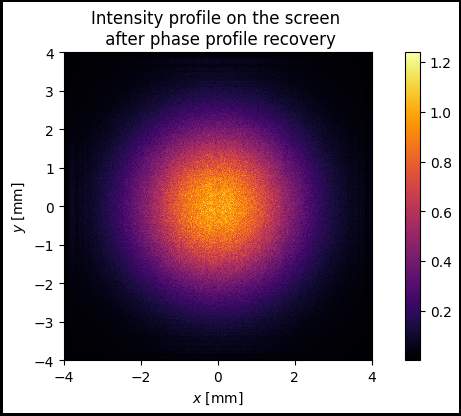

In [38]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity profile on the screen \n after phase profile recovery')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

Highlight the region of interest - region:

In [49]:
region = torch.tensor(xv**2 + yv**2 <= (2.5**2))

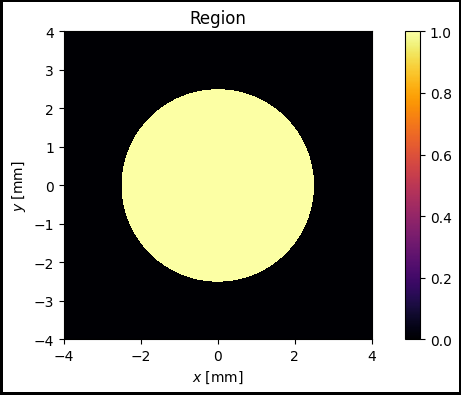

In [50]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, region, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Region')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [51]:
goalx = region[int(Ny/2), :]

goaly = region[:, int(Nx/2)]

indicesx = np.where(goalx == 1.)
indicesy = np.where(goaly == 1.)

Nx_min = indicesx[0][0]
Nx_max = indicesx[0][-1]

Ny_min = indicesy[0][0]
Ny_max = indicesy[0][-1]


# total number of pixels in region
N_total = len(indicesx[0]) * len(indicesy[0])

In [52]:
intensity_target_opt_region = intensity_target_opt[Ny_min:Ny_max, Nx_min:Nx_max]

efficiency = np.sum(intensity_target_opt_region)


average_intensity = efficiency / N_total

maxi = np.max(intensity_target_opt_region)
mini = np.min(intensity_target_opt_region)

uniformity = 1 - (maxi - mini) / (maxi + mini)

standard_error = 100 * np.sum((intensity_target_opt_region - average_intensity)**2)/ (N_total * average_intensity)

eff = np.sum(intensity_target_opt_region) / np.sum(intensity_target_opt) * 100

print('Efficiency:' + str(efficiency))
print('Average intensity:'  + str(average_intensity))
print('Uniformity:' + str(uniformity))
print('Standard error:' + str(standard_error) + '%')

print('Power relation:' + str(eff) + '%')



Efficiency:2186692.468987448
Average intensity:0.45760145218123655
Uniformity:0.06425630734801735
Standard error:12.82710409693719%
Power relation:82.10735971879105%


In [53]:
print(1)

1
